In [149]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.interpolate import make_interp_spline

In [150]:
train = pd.read_csv('../data/train.csv')
X_test = pd.read_csv('../data/test.csv')
y_train = train['Y']
X_train = train.drop('Y', axis=1)
X_train = X_train[['X1', 'X15', 'X12', 'X4']]
num_features = X_train.shape[1]
train.head()

,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15
0,12.083210,16,7,15.9,1,13.6,26,3.6,-20.0,6,2,378,6,7.85,1042.80,6
1,12.433754,19,14,16.4,3,16.7,19,3.5,32.9,0,3,595,11,0.86,83.55,5
2,11.659181,12,14,16.0,2,16.5,17,3.8,45.4,0,2,210,8,1.30,134.29,5
3,15.449989,21,2,16.3,4,9.6,23,3.4,29.0,26,4,1353,10,5.52,736.77,11
4,12.805393,11,11,15.3,2,11.9,22,3.5,35.0,1,3,790,8,1.63,407.42,4


In [151]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=99)

In [152]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)

In [153]:
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())

In [154]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [155]:
EPOCHS = 1000
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_FEATURES = num_features

In [156]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)

In [157]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 16)
        self.bn1 = nn.BatchNorm1d(num_features=16)
        self.layer_2 = nn.Linear(16, 32)
        self.bn2 = nn.BatchNorm1d(num_features=32)
        self.layer_3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(num_features=16)
        self.layer_out = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5) 
        
    def forward(self, inputs):
        x = self.relu(self.bn1(self.layer_1(inputs)))
        x = self.dropout(self.relu(self.bn2(self.layer_2(x))))
        x = self.dropout(self.relu(self.bn3(self.layer_3(x))))
        x = self.layer_out(x)
        return (x)


In [158]:
model = MultipleRegression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MultipleRegression(
  (layer_1): Linear(in_features=4, out_features=16, bias=True)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [159]:
loss_stats = {
    'train': [],
    "val": []
}

In [160]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()

        y_train_pred = model(X_train_batch)
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        train_loss.backward()
        optimizer.step()

        train_epoch_loss += train_loss.item()

    # VALIDATION    
    with torch.no_grad():

        val_epoch_loss = 0

        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            val_epoch_loss += val_loss.item()
    
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 158.63573 | Val Loss: 164.23786
Epoch 002: | Train Loss: 154.17195 | Val Loss: 158.70387
Epoch 003: | Train Loss: 150.07364 | Val Loss: 154.63814
Epoch 004: | Train Loss: 144.75534 | Val Loss: 152.91589
Epoch 005: | Train Loss: 141.45923 | Val Loss: 149.87189
Epoch 006: | Train Loss: 136.95644 | Val Loss: 145.85523
Epoch 007: | Train Loss: 131.36221 | Val Loss: 140.66890
Epoch 008: | Train Loss: 126.16688 | Val Loss: 135.37184
Epoch 009: | Train Loss: 121.52820 | Val Loss: 130.81307
Epoch 010: | Train Loss: 116.51241 | Val Loss: 127.69808
Epoch 011: | Train Loss: 111.79856 | Val Loss: 122.75272
Epoch 012: | Train Loss: 105.65166 | Val Loss: 118.46598
Epoch 013: | Train Loss: 102.03724 | Val Loss: 115.16083
Epoch 014: | Train Loss: 93.79423 | Val Loss: 108.73733
Epoch 015: | Train Loss: 90.32651 | Val Loss: 104.79799
Epoch 016: | Train Loss: 83.70608 | Val Loss: 100.20494
Epoch 017: | Train Loss: 77.97728 | Val Loss: 93.66155
Epoch 018: | Train Loss: 70.75108 | 

Epoch 152: | Train Loss: 12.50919 | Val Loss: 5.58552
Epoch 153: | Train Loss: 14.58443 | Val Loss: 5.39291
Epoch 154: | Train Loss: 13.10442 | Val Loss: 5.62499
Epoch 155: | Train Loss: 12.95581 | Val Loss: 4.96371
Epoch 156: | Train Loss: 13.50327 | Val Loss: 5.08880
Epoch 157: | Train Loss: 13.32085 | Val Loss: 5.91028
Epoch 158: | Train Loss: 12.43786 | Val Loss: 5.60799
Epoch 159: | Train Loss: 12.72793 | Val Loss: 5.81635
Epoch 160: | Train Loss: 13.24923 | Val Loss: 5.66228
Epoch 161: | Train Loss: 12.35856 | Val Loss: 5.41387
Epoch 162: | Train Loss: 13.43643 | Val Loss: 5.51598
Epoch 163: | Train Loss: 12.65214 | Val Loss: 5.82176
Epoch 164: | Train Loss: 11.51357 | Val Loss: 5.58461
Epoch 165: | Train Loss: 12.49868 | Val Loss: 5.59823
Epoch 166: | Train Loss: 13.21264 | Val Loss: 5.23838
Epoch 167: | Train Loss: 11.85556 | Val Loss: 5.03281
Epoch 168: | Train Loss: 11.96102 | Val Loss: 4.80930
Epoch 169: | Train Loss: 13.28359 | Val Loss: 4.64659
Epoch 170: | Train Loss: 12.

Epoch 306: | Train Loss: 9.19762 | Val Loss: 3.52182
Epoch 307: | Train Loss: 8.76813 | Val Loss: 3.25738
Epoch 308: | Train Loss: 8.91433 | Val Loss: 3.36353
Epoch 309: | Train Loss: 8.69849 | Val Loss: 3.48638
Epoch 310: | Train Loss: 9.34113 | Val Loss: 3.68880
Epoch 311: | Train Loss: 8.41136 | Val Loss: 3.65517
Epoch 312: | Train Loss: 7.79271 | Val Loss: 3.57629
Epoch 313: | Train Loss: 9.05178 | Val Loss: 3.45420
Epoch 314: | Train Loss: 8.33613 | Val Loss: 3.53683
Epoch 315: | Train Loss: 8.12102 | Val Loss: 3.69878
Epoch 316: | Train Loss: 7.70995 | Val Loss: 3.50930
Epoch 317: | Train Loss: 8.45294 | Val Loss: 3.43847
Epoch 318: | Train Loss: 9.33109 | Val Loss: 3.50049
Epoch 319: | Train Loss: 8.34408 | Val Loss: 3.44386
Epoch 320: | Train Loss: 8.30964 | Val Loss: 3.34792
Epoch 321: | Train Loss: 9.23640 | Val Loss: 3.58910
Epoch 322: | Train Loss: 8.68727 | Val Loss: 3.65900
Epoch 323: | Train Loss: 8.31727 | Val Loss: 3.54393
Epoch 324: | Train Loss: 8.70445 | Val Loss: 3

Epoch 462: | Train Loss: 6.68276 | Val Loss: 2.88690
Epoch 463: | Train Loss: 6.30885 | Val Loss: 2.89151
Epoch 464: | Train Loss: 5.73334 | Val Loss: 3.00467
Epoch 465: | Train Loss: 5.94051 | Val Loss: 2.83266
Epoch 466: | Train Loss: 6.41583 | Val Loss: 2.76948
Epoch 467: | Train Loss: 5.72563 | Val Loss: 2.76944
Epoch 468: | Train Loss: 5.41769 | Val Loss: 2.88775
Epoch 469: | Train Loss: 5.82118 | Val Loss: 2.89926
Epoch 470: | Train Loss: 6.79123 | Val Loss: 2.90685
Epoch 471: | Train Loss: 5.95722 | Val Loss: 2.99456
Epoch 472: | Train Loss: 6.04151 | Val Loss: 2.84604
Epoch 473: | Train Loss: 6.10980 | Val Loss: 2.82138
Epoch 474: | Train Loss: 5.33549 | Val Loss: 2.84908
Epoch 475: | Train Loss: 5.64678 | Val Loss: 2.90174
Epoch 476: | Train Loss: 5.31335 | Val Loss: 2.89095
Epoch 477: | Train Loss: 6.11898 | Val Loss: 2.88972
Epoch 478: | Train Loss: 5.56433 | Val Loss: 2.87471
Epoch 479: | Train Loss: 4.89833 | Val Loss: 2.84406
Epoch 480: | Train Loss: 5.53557 | Val Loss: 2

Epoch 617: | Train Loss: 4.25548 | Val Loss: 2.56732
Epoch 618: | Train Loss: 3.96141 | Val Loss: 2.51958
Epoch 619: | Train Loss: 4.04398 | Val Loss: 2.56292
Epoch 620: | Train Loss: 3.78668 | Val Loss: 2.58269
Epoch 621: | Train Loss: 3.93010 | Val Loss: 2.57378
Epoch 622: | Train Loss: 4.02394 | Val Loss: 2.57986
Epoch 623: | Train Loss: 3.78914 | Val Loss: 2.56109
Epoch 624: | Train Loss: 3.68602 | Val Loss: 2.58595
Epoch 625: | Train Loss: 3.83016 | Val Loss: 2.56646
Epoch 626: | Train Loss: 3.83547 | Val Loss: 2.65667
Epoch 627: | Train Loss: 3.73988 | Val Loss: 2.58744
Epoch 628: | Train Loss: 4.57781 | Val Loss: 2.61369
Epoch 629: | Train Loss: 3.78790 | Val Loss: 2.61996
Epoch 630: | Train Loss: 3.74855 | Val Loss: 2.55046
Epoch 631: | Train Loss: 3.67259 | Val Loss: 2.52511
Epoch 632: | Train Loss: 3.91243 | Val Loss: 2.55744
Epoch 633: | Train Loss: 4.25441 | Val Loss: 2.56285
Epoch 634: | Train Loss: 4.03808 | Val Loss: 2.61590
Epoch 635: | Train Loss: 4.06993 | Val Loss: 2

Epoch 773: | Train Loss: 2.87016 | Val Loss: 2.37435
Epoch 774: | Train Loss: 2.90688 | Val Loss: 2.40059
Epoch 775: | Train Loss: 2.89762 | Val Loss: 2.36696
Epoch 776: | Train Loss: 2.94705 | Val Loss: 2.37997
Epoch 777: | Train Loss: 2.92768 | Val Loss: 2.34852
Epoch 778: | Train Loss: 2.99475 | Val Loss: 2.31974
Epoch 779: | Train Loss: 2.79797 | Val Loss: 2.36435
Epoch 780: | Train Loss: 2.98863 | Val Loss: 2.36423
Epoch 781: | Train Loss: 2.74148 | Val Loss: 2.34757
Epoch 782: | Train Loss: 2.90330 | Val Loss: 2.37280
Epoch 783: | Train Loss: 2.59727 | Val Loss: 2.34084
Epoch 784: | Train Loss: 2.59872 | Val Loss: 2.31547
Epoch 785: | Train Loss: 2.80566 | Val Loss: 2.34996
Epoch 786: | Train Loss: 2.71136 | Val Loss: 2.35549
Epoch 787: | Train Loss: 2.62351 | Val Loss: 2.36550
Epoch 788: | Train Loss: 2.60517 | Val Loss: 2.35341
Epoch 789: | Train Loss: 2.81862 | Val Loss: 2.36867
Epoch 790: | Train Loss: 2.59486 | Val Loss: 2.33236
Epoch 791: | Train Loss: 2.76131 | Val Loss: 2

Epoch 929: | Train Loss: 2.12454 | Val Loss: 2.28709
Epoch 930: | Train Loss: 2.07853 | Val Loss: 2.27845
Epoch 931: | Train Loss: 2.18543 | Val Loss: 2.25950
Epoch 932: | Train Loss: 2.19009 | Val Loss: 2.26465
Epoch 933: | Train Loss: 2.34109 | Val Loss: 2.32503
Epoch 934: | Train Loss: 1.99769 | Val Loss: 2.31580
Epoch 935: | Train Loss: 2.12041 | Val Loss: 2.26884
Epoch 936: | Train Loss: 2.26351 | Val Loss: 2.28166
Epoch 937: | Train Loss: 2.12457 | Val Loss: 2.28735
Epoch 938: | Train Loss: 2.16877 | Val Loss: 2.35258
Epoch 939: | Train Loss: 2.17881 | Val Loss: 2.32606
Epoch 940: | Train Loss: 2.09513 | Val Loss: 2.29898
Epoch 941: | Train Loss: 2.18992 | Val Loss: 2.26596
Epoch 942: | Train Loss: 2.16702 | Val Loss: 2.26316
Epoch 943: | Train Loss: 2.06704 | Val Loss: 2.26918
Epoch 944: | Train Loss: 2.21019 | Val Loss: 2.28205
Epoch 945: | Train Loss: 2.12697 | Val Loss: 2.27179
Epoch 946: | Train Loss: 2.18947 | Val Loss: 2.27367
Epoch 947: | Train Loss: 2.07921 | Val Loss: 2

(0.0, 30.0)

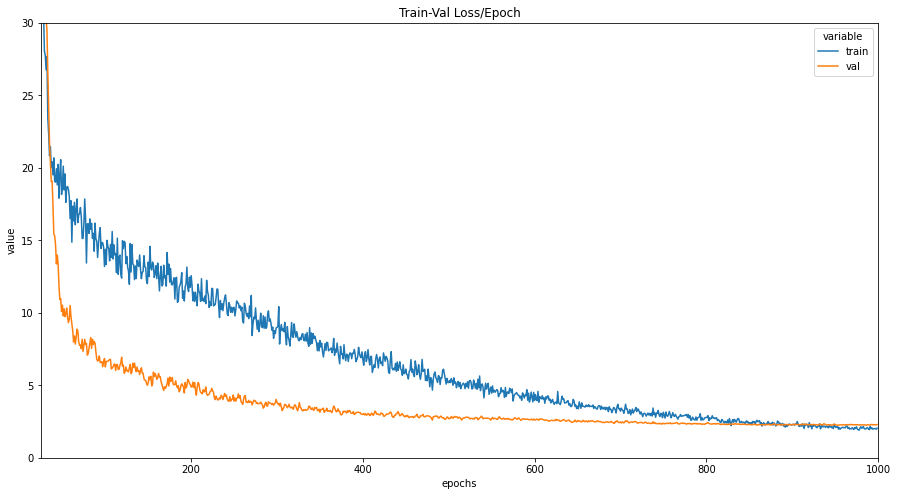

In [161]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')
plt.xlim([25, EPOCHS])
plt.ylim([0, 30])
